In [ ]:
from pymongo import MongoClient
from bson import ObjectId
import pandas as pd
from datetime import datetime as datetime
client = MongoClient("mongodb://localhost:27017")

db = client["lifesnaps"] 
collection = db["fitbit"]

userID = ObjectId("621e2f9167b776a240011ccb")



QRY en Projection instellen + query uitvoeren en in dataframe steken

In [39]:
qry = {
    "id": userID,
    "type": "heart_rate",
  }
projection = {
    "_id": 0
}
rawDocs = list(collection.find(qry,projection))

# Convert to DataFrame
flatDocs = []
for doc in rawDocs:
    data = doc.get("data",{})
    value = data.get("value",{})
    
    if value["confidence"] > 0:

        flatDocs.append({
            "dateTime": data["dateTime"],
            "heartrate": value["bpm"]        
    })


df = pd.DataFrame(flatDocs)
df["dateTime"] = pd.to_datetime(df["dateTime"], errors='coerce')
df["heartrate"] = pd.to_numeric(df["heartrate"], errors='coerce')

In [ ]:
df.head()
df["datetime_day"] = df["dateTime"].dt.floor("D")

avgHeartratePerDay = df.groupby("datetime_day")["heartrate"].mean()
print(avgHeartratePerDay)

datetime_hour
2021-10-23    84.603987
2021-10-24    78.530959
2021-10-25    74.846546
2021-10-26    79.038225
2021-10-27    78.103234
                ...    
2022-01-15    74.053258
2022-01-16    71.922696
2022-01-17    75.564932
2022-01-18    71.826988
2022-01-19    72.090086
Name: heartrate, Length: 89, dtype: float64


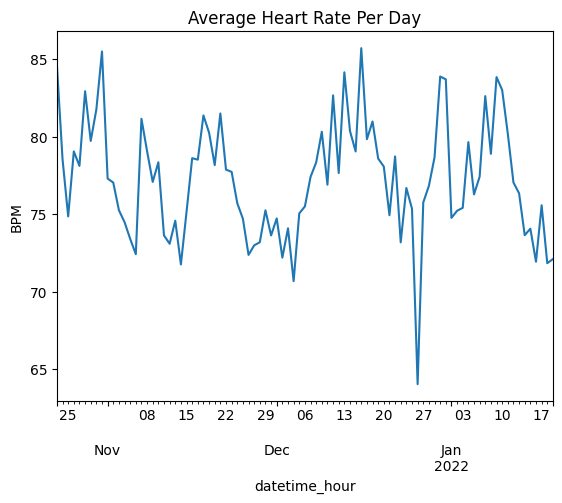

In [ ]:
import matplotlib.pyplot as plt

avgHeartratePerDay.plot(title="Average Heart Rate Per Day", ylabel="BPM")
plt.show()

In [ ]:

#voor bepaalde dag

chosenDay = input()
targetDay = pd.to_datetime(chosenDay).date()

# Filter only rows from the target date
dfDay = df[df["dateTime"].dt.date == targetDay]

# Group by hour of the day
dfDay["hour"] = dfDay["dateTime"].dt.hour
avgHeartratePerHour = dfDay.groupby("hour")["heartrate"].mean()

print(avgHeartratePerHour)

dfChosenDay = df["dateTime"].dt.floor("H")


C:\Users\Arnout Plettinx\AppData\Local\Temp\ipykernel_22032\1041635452.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  targetDay = pd.to_datetime(chosenDay).date()


KeyError: 'datetime'